# CEBRA

In [2]:
import torch
torch.cuda.is_available()

True

## test CEBRA 

In [1]:
# import 
import numpy as np
import cebra
from cebra import CEBRA
import pandas as pd
import tempfile
from pathlib import Path
import sys
import os
import pickle
from pathlib import Path
import configparser
config = configparser.ConfigParser()
config.read_file(open('../../privateconfig'))
resdir = Path(config['Datafolder']['data'])
workdir = Path(config['Codefolder']['workspace'])
os.chdir(workdir)
from notification import notify

In [6]:
# fake data test
# timesteps = 50000
# neurons = 50
# out_dim = 3

# neural_data = np.random.normal(0,1,(timesteps, neurons))
# continuous_label = np.random.normal(0,1,(timesteps, 3))
# discrete_label = np.random.randint(0,10,(timesteps,2))
# neural_data.shape, continuous_label.shape, discrete_label.shape

((50000, 50), (50000, 3), (50000, 2))

In [3]:
# use my data
with open(f'{workdir}/test/neural/cebra/test','rb') as f:
    (neural_data,continuous_label)=pickle.load(f)
neural_data.shape, continuous_label.shape

((18985, 94), (18985, 13))

In [4]:
timesteps = neural_data.shape[0]
neurons = neural_data.shape[1]
out_dim = 3
max_iterations=5*3600 # 1 hr training per fit
time_offsets=4 # 0.1 s

single_cebra_model = CEBRA(model_architecture='offset10-model',
                        batch_size=None, # whole dataset
                        learning_rate=0.001,
                        # temperature_mode="auto",
                        temperature=1,
                        output_dimension=out_dim,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda:0',
                        verbose=True,
                        time_offsets=time_offsets)

# single_cebra_model.fit(neural_data, continuous_label[:,[0,2,4,6,12,]])
# embedding = single_cebra_model.transform(neural_data)
# assert(embedding.shape == (timesteps, out_dim))
# notify('cebra ready')

In [5]:
# further training
for i in range(5):
    single_cebra_model.fit(neural_data, continuous_label[:,[0,2,4,6,12,]])
    tmp_file = Path(f'{workdir}/test/neural/cebra/', f'cebra024612_0309_{i+1}hr.pt')
    single_cebra_model.save(tmp_file)
    notify(f'cebra {i} ready')

pos: -0.6942 neg:  10.0367 total:  9.3425 temperature:  1.0000: 100%|██████████| 18000/18000 [50:17<00:00,  5.97it/s]
pos: -0.7093 neg:  10.0368 total:  9.3275 temperature:  1.0000: 100%|██████████| 18000/18000 [50:07<00:00,  5.98it/s]
pos: -0.6127 neg:  10.0668 total:  9.4540 temperature:  1.0000:  12%|█▏        | 2108/18000 [05:53<45:44,  5.79it/s]

In [133]:
# save and load

# tmp_file = Path(f'{workdir}/test/neural/cebra/', 'cebra3hr024612.pt')
# single_cebra_model.save(tmp_file)



# # New session: load and use the model
# loaded_cebra_model = cebra.CEBRA.load(tmp_file)
# embedding = loaded_cebra_model.transform(neural_data)

Text(0.5, 1.0, 'training loss')

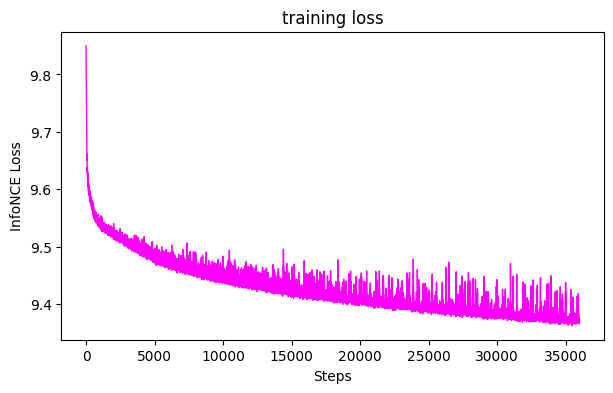

In [132]:
%matplotlib inline

ax=cebra.plot_loss(single_cebra_model)
ax.set_title('training loss')

# ax=cebra.plot_temperature(single_cebra_model)
# ax.set_title('temperature')


In [125]:
from matplotlib import pyplot as plt

def plot_embedding_contrast(ax, embedding, label, gray = False, beh_idx=(0,1), idx_order = (0,1,2)):

    if not gray:
        r_cmap = 'cool'
        r_c = label[:, beh_idx[0]]-label[:, beh_idx[1]]
    else:
        r_cmap = None
        r_c = 'gray'
    

    idx1, idx2, idx3 = idx_order
    r=ax.scatter(embedding [:,idx1],
               embedding [:,idx2],
               embedding [:,idx3],
               c=r_c,
            #    vmin=0,
            #    vmax=1,
               cmap=r_cmap, s=0.5)
    plt.colorbar(r)

    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.set_ticks([-1,0,1])
    ax.yaxis.set_ticks([-1,0,1])
    ax.zaxis.set_ticks([-1,0,1])
    ax.set_xlabel('dim 1')
    ax.set_ylabel('dim 2')
    ax.set_zlabel('dim 3')
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.axis('equal')
    return ax

def plot_embedding(ax, embedding, label, gray = False, beh_idx=0, idx_order = (0,1,2)):

    if not gray:
        r_cmap = 'cool'
        r_c = label[:, beh_idx]
    else:
        r_cmap = None
        r_c = 'gray'
    

    idx1, idx2, idx3 = idx_order
    r=ax.scatter(embedding [:,idx1],
               embedding [:,idx2],
               embedding [:,idx3],
               c=r_c,
               vmin=0,
               vmax=1,
               cmap=r_cmap, s=0.5)
    plt.colorbar(r)

    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.set_ticks([-1,0,1])
    ax.yaxis.set_ticks([-1,0,1])
    ax.zaxis.set_ticks([-1,0,1])
    ax.set_xlabel('dim 1')
    ax.set_ylabel('dim 2')
    ax.set_zlabel('dim 3')
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.axis('equal')
    return ax

def plot_embedding2d(ax, embedding, label, gray = False, beh_idx=0, idx_order = (0,1)):

    if not gray:
        r_cmap = 'cool'
        r_c = label[:, beh_idx]
    else:
        r_cmap = None
        r_c = 'gray'
    

    idx1, idx2 = idx_order
    r=ax.scatter(embedding [:,idx1],
               embedding [:,idx2],
               c=r_c,
               vmin=0,
               vmax=1,
               cmap=r_cmap, s=0.5)
    plt.colorbar(r)

    ax.grid(False)

 
    ax.xaxis.set_ticks([-1,0,1])
    ax.yaxis.set_ticks([-1,0,1])
 
    ax.set_xlabel('dim 1')
    ax.set_ylabel('dim 2')

    ax.axis('equal')


    return ax

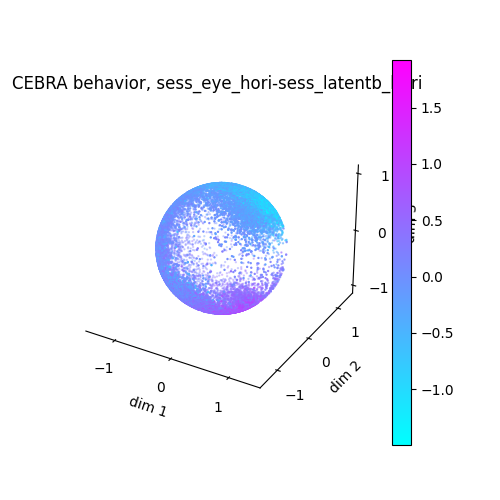

In [134]:

%matplotlib widget
fig = plt.figure(figsize=(5,5))
ax1 = plt.subplot(111, projection='3d')
ax1=plot_embedding_contrast(ax1, embedding, continuous_label, beh_idx=[2,4])

thisyname=[
    'sess_latentff_hori',
    'sess_latentff_vert',
    'sess_eye_hori',
    'sess_eye_vert',
    'sess_latentb_hori',
    'sess_latentb_vert',
    '(sess_angle_from_start)',
    ('sess_ll_t'),
    ('sess_t'),
    ('sess_err'),
    ('sess_err_belief'),
    ('sess_angle_from_start_belief'),
    (('belief_heading')), # belief heading
]

ax1.set_title(f'CEBRA behavior, {thisyname[2]}-{thisyname[4]}')

plt.show()

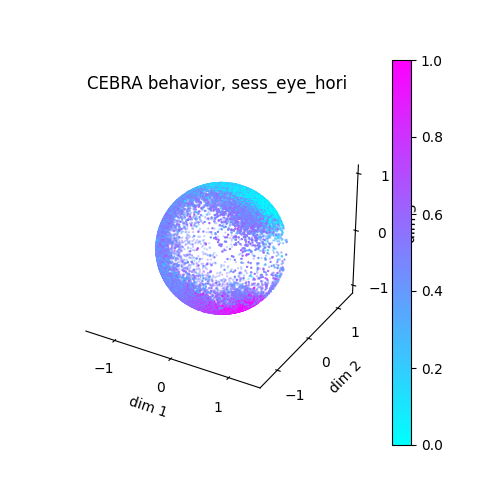

In [139]:
beh_idx    =      2


%matplotlib widget
fig = plt.figure(figsize=(5,5))
ax1 = plt.subplot(111, projection='3d')
ax1=plot_embedding(ax1, embedding, continuous_label, beh_idx=beh_idx)

thisyname=[
    'sess_latentff_hori',
    'sess_latentff_vert',
    'sess_eye_hori',
    'sess_eye_vert',
    'sess_latentb_hori',
    'sess_latentb_vert',
    '(sess_angle_from_start)',
    ('sess_ll_t'),
    ('sess_t'),
    ('sess_err'),
    ('sess_err_belief'),
    ('sess_angle_from_start_belief'),
    (('belief_heading')), # belief heading
]

ax1.set_title(f'CEBRA behavior, {thisyname[beh_idx]}')
plt.show()


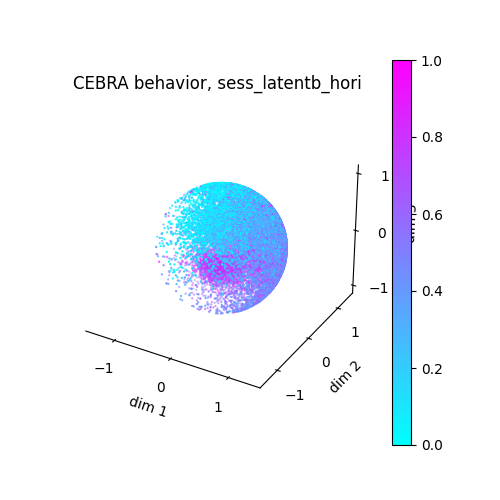

In [119]:
beh_idx    =      4
%matplotlib widget
fig = plt.figure(figsize=(5,5))
ax1 = plt.subplot(111, projection='3d')
ax1=plot_embedding(ax1, embedding, continuous_label, beh_idx=beh_idx)


ax1.set_title(f'CEBRA behavior, {thisyname[4]}')

plt.show()


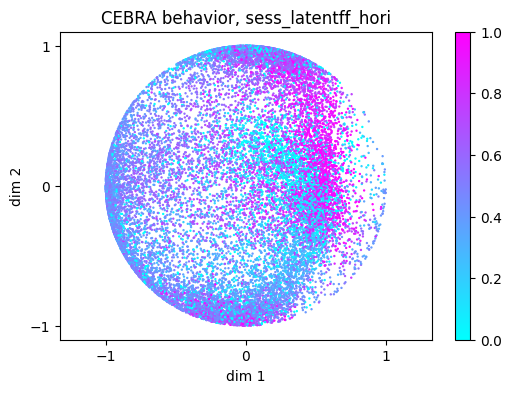

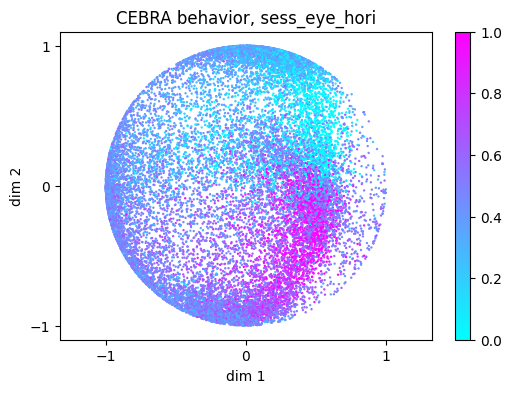

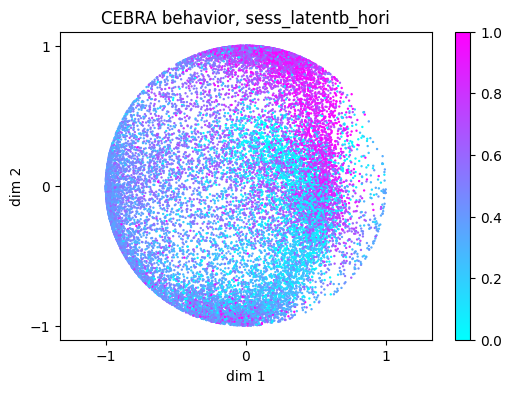

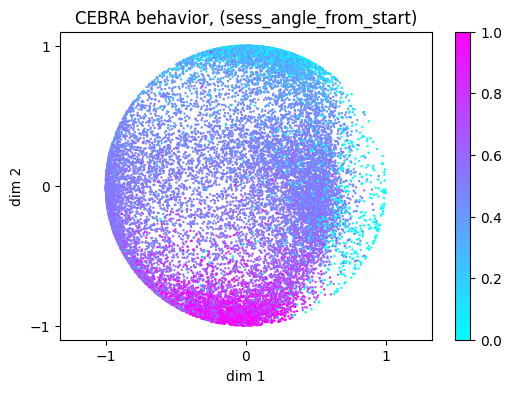

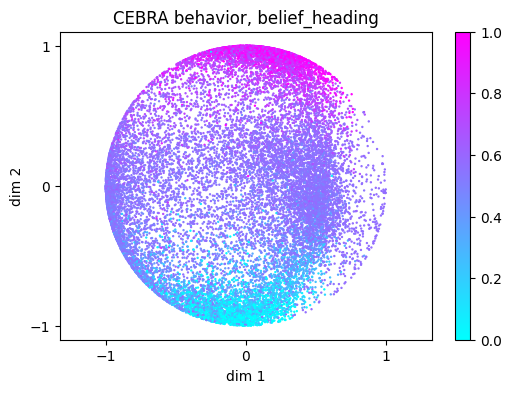

In [138]:
%matplotlib inline

for beh_idx in [0,2,4,6,12]:
    
    fig = plt.figure(figsize=(6,4))
    ax1 = plt.subplot(111)
    ax1=plot_embedding2d(ax1, embedding, continuous_label, beh_idx=beh_idx)

    ax1.set_title(f'CEBRA behavior, {thisyname[beh_idx]}')

    plt.show()

In [ ]:
# try full latent dim, and plot individual latent dstate

In [ ]:
# subtraction, unit